In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os import environ
from pathlib import Path
from typing import List

import torch
import pandas as pd
import numpy as np

from hydra import initialize, compose
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf

import matplotlib.pyplot as plt

from bliss.surveys.des import DarkEnergySurvey, DESDownloader

from pathlib import Path
from hydra import initialize, compose
from bliss.main import predict

In [3]:
environ["CUDA_VISIBLE_DEVICES"] = "4"
environ["BLISS_HOME"] = "/home/kapnadak/bliss/"

In [4]:
#environ["BLISS_HOME"] = str(Path().resolve().parents[1])
with initialize(config_path="../", version_base=None):
    cfg = compose("config", {
        "encoder.tiles_to_crop=0",
        })

In [5]:
encoder = instantiate(cfg.predict.encoder)
enc_state_dict = torch.load(cfg.predict.weight_save_path)
enc_state_dict = enc_state_dict["state_dict"]
encoder.load_state_dict(enc_state_dict)
dataset = instantiate(cfg.cached_simulator)
trainer = instantiate(cfg.predict.trainer)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
enc_output = trainer.predict(encoder, datamodule=dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]


Predicting: 0it [00:00, ?it/s]

In [8]:
dataloader_iter = iter(dataset.predict_dataloader())

In [9]:
def create_overlay(predictions, tile_size):
    overlay = torch.zeros((predictions.size(0) * tile_size, predictions.size(1) * tile_size, 3))
    detection_color = torch.tensor([0.0, 1.0, 0.0])  # Green color
    non_detection_color = torch.tensor([1.0, 0.0, 0.0])  # Red color
    for i in range(predictions.size(0)):
        for j in range(predictions.size(1)):
            color = detection_color if predictions[i, j] == 1 else non_detection_color
            overlay[i*tile_size:(i+1)*tile_size, j*tile_size:(j+1)*tile_size] = color
    return overlay

def blend_images(original, overlay, alpha=0.5, img_crop=0):
    # Ensure the original image is in float
    if original.max() > 1.0:
        original = original / 255.0
    # Blend the images
    blended = original * (1 - alpha) + overlay * alpha
    blended = blended[img_crop: blended.size(0) - img_crop, img_crop: blended.size(1) - img_crop]
    print(blended.shape)
    return blended

def compute_metrics(est_cat, true_cat):
    true_positives = (est_cat & true_cat).sum(dtype=torch.float32)
    false_positives = (est_cat & ~true_cat).sum(dtype=torch.float32)
    false_negatives = (~est_cat & true_cat).sum(dtype=torch.float32)
    true_negatives = (~est_cat & ~true_cat).sum(dtype=torch.float32)

    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    precision = true_positives / (true_positives + false_positives + 1e-6)  # Avoid division by zero
    recall = true_positives / (true_positives + false_negatives + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

    return accuracy.item(), precision.item(), recall.item(), f1.item()
    

In [72]:
batch_id = 2
dataloader_iter = iter(dataset.predict_dataloader())
for i in range(batch_id):
    truth = next(dataloader_iter)
    outputs = enc_output[i]

In [73]:
tile_size = 128
shift_size = int(tile_size / 2)
shifted_images_1 = torch.roll(truth["images"], (0,0,shift_size,shift_size), (0,1,2,3))
shifted_images_2 = torch.roll(truth["images"], (0,0,-shift_size,-shift_size), (0,1,2,3))

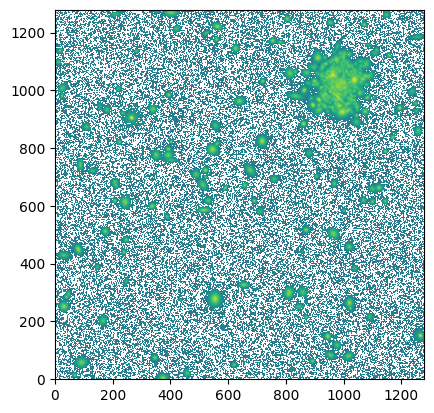

In [74]:
from matplotlib.colors import LogNorm
plt.imshow(truth["images"][0,0,:,:], norm=LogNorm(), origin="lower")

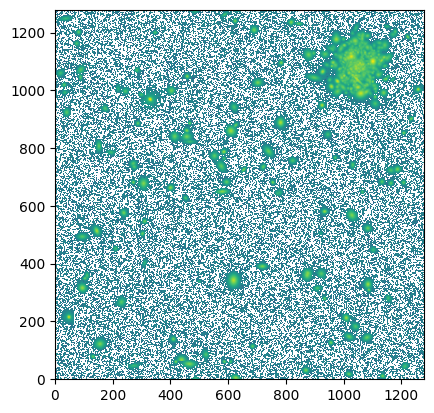

In [75]:
plt.imshow(shifted_images_1[0,0,:,:], norm=LogNorm(), origin="lower")

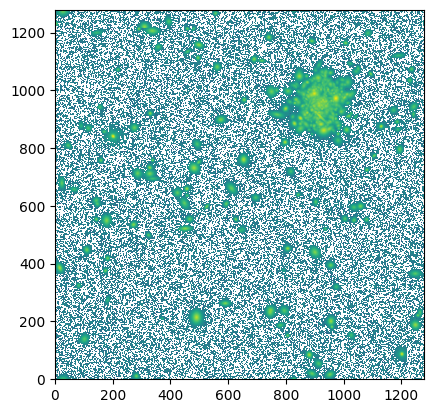

In [76]:
plt.imshow(shifted_images_2[0,0,:,:], norm=LogNorm(), origin="lower")

In [77]:
outputs["mode_cat"]["membership"][0].squeeze().shape

torch.Size([10, 10])

In [78]:
truth_tensor = encoder.image_normalizer.get_input_tensor(truth)

In [79]:
truth_tensor.shape

torch.Size([2, 4, 1, 1280, 1280])

In [80]:
shifted_images_1 = shifted_images_1.unsqueeze(2)
shifted_images_2 = shifted_images_2.unsqueeze(2)
shifted_images_1.shape, shifted_images_2.shape

(torch.Size([2, 4, 1, 1280, 1280]), torch.Size([2, 4, 1, 1280, 1280]))

In [81]:
x1 = encoder.features_net(shifted_images_1)
x2 = encoder.features_net(shifted_images_2)

In [82]:
x_cat1 = encoder.marginal_net(x1)
x_cat2 = encoder.marginal_net(x2)

In [84]:
marginal_cat1 = encoder.var_dist.sample(x_cat1, use_mode=True)
marginal_cat2 = encoder.var_dist.sample(x_cat2, use_mode=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1280, 1280, 3])
Image statistics:
 Accuracy:0.9800000190734863, 
 Precision: 0.9999997615814209,
 Recall: 0.666666567325592, 
 F1: 0.7999994158744812


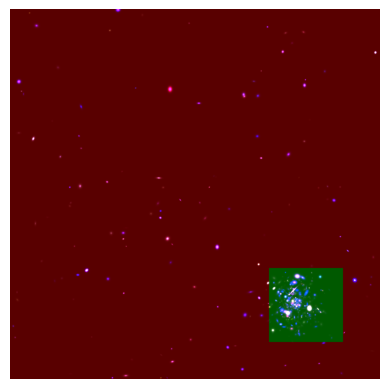

In [86]:

# img_id selects for an image within the batch, i.e., from 0 to batch_size - 1
img_id = 0
crop = 0
n_tiles = 10
tile_size = 128
img_size = 1280

band_idx = {
    "g": 0,
    "r": 1,
    "i": 2,
    "z": 3
}


est_cat = outputs["mode_cat"]["membership"][img_id, crop: n_tiles - crop + 1, crop: n_tiles - crop + 1].to(torch.bool)
true_cat = truth["tile_catalog"]["membership"][img_id, crop: n_tiles - crop + 1, crop: n_tiles - crop + 1].to(torch.bool)

img_acc, img_prec, img_rec, img_f1 =  compute_metrics(est_cat, true_cat)

test_img = truth["images"][img_id][[band_idx["g"], band_idx["r"], band_idx["z"]]]
test_out = outputs["mode_cat"]["membership"][img_id].squeeze()
overlay = create_overlay(test_out, tile_size=128)
blended_image = blend_images(test_img.permute(1,2,0), overlay, alpha=0.35, img_crop=crop*tile_size)

print(f"Image statistics:\n Accuracy:{img_acc}, \n Precision: {img_prec},\n Recall: {img_rec}, \n F1: {img_f1}")
plt.imshow(blended_image)
plt.axis('off')
plt.show()

In [92]:
outs1 = outputs["mode_cat"]["membership"][0].squeeze()
outs2 = marginal_cat1["membership"][0].squeeze()
outs3 = marginal_cat2["membership"][0].squeeze()

outs_final = (outs1 + outs2 + outs3 > 0)
outs_final

tensor([[False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False,  True,  True, False, False],
        [False, False, False, False, False, False,  True,  True,  True, False],
        [False, False, False, False, False, False,  True,  True,  True, False],
        [False, False, False, False, False, False, False, False, False, False]])

In [93]:
truth["tile_catalog"]["membership"][0].squeeze()

tensor([[False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False,  True,  True,  True, False],
        [False, False, False, False, False, False,  True,  True,  True, False],
        [False, False, False, False, False, False, False, False, False, False]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1280, 1280, 3])
Image statistics:
 Accuracy:0.9800000190734863, 
 Precision: 0.9999997615814209,
 Recall: 0.666666567325592, 
 F1: 0.7999994158744812


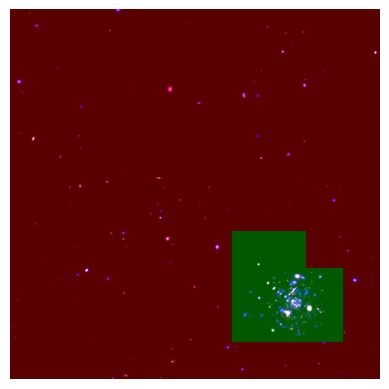

In [96]:

# img_id selects for an image within the batch, i.e., from 0 to batch_size - 1
img_id = 0
crop = 0
n_tiles = 10
tile_size = 128
img_size = 1280

band_idx = {
    "g": 0,
    "r": 1,
    "i": 2,
    "z": 3
}


est_cat = outputs["mode_cat"]["membership"][img_id, crop: n_tiles - crop + 1, crop: n_tiles - crop + 1].to(torch.bool)
true_cat = truth["tile_catalog"]["membership"][img_id, crop: n_tiles - crop + 1, crop: n_tiles - crop + 1].to(torch.bool)

img_acc, img_prec, img_rec, img_f1 =  compute_metrics(est_cat, true_cat)

test_img = truth["images"][img_id][[band_idx["g"], band_idx["r"], band_idx["z"]]]
#test_out = outputs["mode_cat"]["membership"][img_id].squeeze()
overlay = create_overlay(outs_final, tile_size=128)
blended_image = blend_images(test_img.permute(1,2,0), overlay, alpha=0.35, img_crop=crop*tile_size)

print(f"Image statistics:\n Accuracy:{img_acc}, \n Precision: {img_prec},\n Recall: {img_rec}, \n F1: {img_f1}")
plt.imshow(blended_image)
plt.axis('off')
plt.show()

In [100]:
outs_final.view(10,10)

tensor([[False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False,  True,  True, False, False],
        [False, False, False, False, False, False,  True,  True,  True, False],
        [False, False, False, False, False, False,  True,  True,  True, False],
        [False, False, False, False, False, False, False, False, False, False]])